In [1]:
import pandas as pd
import numpy as np
from pypfopt import risk_models, expected_returns, plotting, EfficientFrontier
import matplotlib.pyplot as plt
from datetime import date, timedelta, datetime
#pypfopt.__version__
import quantstats as qs
import yfinance as yf
import tempfile
import plotly.express as px
from bs4 import BeautifulSoup
import requests
import yesg

https://medium.com/enjoy-algorithm/pre-processing-of-time-series-data-c50f8a3e7a98

https://www.kaggle.com/code/harshalnikose/portfolio-management
https://medium.com/cloudcraftz/portfolio-trading-using-pyportfolioopt-24040247249


In [61]:
link = 'https://www.finance.yahoo.com/quote/AAPL/sustainability?p=AAPL'
headers = {'user-agent': 'Mozilla/5.0 (Windows NT 10.0; Win64; x64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/95.0.4638.54 Safari/537.36 Edg/95.0.1020.30',}

res = requests.get(link,headers=headers)
soup_aapl = BeautifulSoup(res.content, 'html.parser')

In [20]:
#headlines = soup.find_all('')
for e in soup.select('div:has(>h3>a)'):
    print(e.h3.text)
    try:
        print(e.p.text)
    except:
        print(None)
    if e.a['href'].startswith('https://'):
        print(e.a['href'])
    else:
        print('http://www.finance.yahoo.com'+e.a['href'])
    print()

Asian shares rise as S&P 500 records longest win streak in two years
Asian share markets rallied on Thursday and the dollar was weaker after most U.S stocks edged higher and the S&P 500 recorded its longest winning streak in two years, with investors on high alert for signs that global interest rates have peaked.  The yield on benchmark 10-year Treasury notes  reached 4.5059% compared with a U.S. close of 4.523% on Wednesday.  The two-year yield, which rises with traders' expectations of higher Fed fund rates, touched 4.932% compared with a U.S. close of 4.936%.
http://www.finance.yahoo.com/news/asian-shares-rise-p-500-022710385.html

BOJ may end negative rates in January, ex-central bank executive says
The Bank of Japan may end its negative interest rate policy as early as January, and keep raising short-term borrowing costs if the economy can weather risks from overseas uncertainties, said former central bank executive Eiji Maeda.  The BOJ last month revised up its price estimates to

In [21]:
def dl_yh_news(link='https://www.finance.yahoo.com/news'):
    res = requests.get(link)
    soup = BeautifulSoup(res.content, 'html.parser')
    news = []
    for e in soup.select('div:has(>h3>a)'):
        try: # Some may not contain content
            text = e.p.text
        except:
            text = ' '
        if e.a['href'].startswith('https://'):
            link = e.a['href']
        else:
            link = 'http://www.finance.yahoo.com' + e.a['href']

        news.append((e.h3.text, link, text))
    return pd.DataFrame(news, columns=['title', 'link', 'desc'])

In [25]:
temp = dl_yh_news('https://www.finance.yahoo.com/quote/AAPL?p=AAPL&.tsrc=fin-srch')


In [25]:
def dl_stock_data(tickers, period=None, interval='1d', start="2021-01-01", end=date.today(), col='Adj Close'):
    if period:
        stock_data = yf.download(tickers, period=period, interval=interval)
    else:
        stock_data = yf.download(tickers, interval=interval, start=start, end=end)
    if stock_data.empty:
        raise Exception('Empty Dataframe')
    if col in ['Open', 'High', 'Low', 'Close', 'Adj Close', 'Volume']:
        stock_data = stock_data[col]
    else:
        raise NameError('Invalid Column Name')
    return stock_data

In [91]:
def test_ef():
    companies = ["MSFT", "AMZN", "META", "BABA", "GE", "GOOG", "AMD", "WMT", "BAC", "GM", "T", "UAA", "MA", "PFE", "JPM", "SBUX"]
    stock_data = yf.download(companies, start="2020-6-01", end=date.today())
    stock_data = stock_data["Adj Close"]
    mu2 = expected_returns.mean_historical_return(stock_data)
    cov_matrix2 = risk_models.sample_cov(stock_data)
    temp_ef = EfficientFrontier(mu2, cov_matrix2)
    return temp_ef, cov_matrix2

In [72]:
companies = ["MSFT", "AMZN", "META", "BABA", "GE", "GOOG", "AMD", "WMT", "BAC", "GM", "T", "UAA", "MA", "PFE", "JPM", "SBUX"]

In [73]:
stock_data = yf.download(companies, start="2020-6-01", end=date.today())

[*********************100%%**********************]  16 of 16 completed


In [38]:

stock_data = dl_stock_data('MSFT', interval='1m', start='2023-11-10', end='2023-11-11')


[*********************100%%**********************]  1 of 1 completed


In [39]:
stock_data

Datetime
2023-11-10 09:30:00-05:00    361.220001
2023-11-10 09:31:00-05:00    362.279999
2023-11-10 09:32:00-05:00    361.859985
2023-11-10 09:33:00-05:00    362.119995
2023-11-10 09:34:00-05:00    362.059998
                                ...    
2023-11-10 15:55:00-05:00    369.450012
2023-11-10 15:56:00-05:00    369.595001
2023-11-10 15:57:00-05:00    369.589996
2023-11-10 15:58:00-05:00    369.519989
2023-11-10 15:59:00-05:00    369.519989
Name: Adj Close, Length: 390, dtype: float64

In [10]:
stock_data.index

DatetimeIndex(['2023-11-09 09:30:00-05:00', '2023-11-09 09:31:00-05:00',
               '2023-11-09 09:33:00-05:00', '2023-11-09 09:34:00-05:00',
               '2023-11-09 09:35:00-05:00', '2023-11-09 09:36:00-05:00',
               '2023-11-09 09:37:00-05:00', '2023-11-09 09:38:00-05:00',
               '2023-11-09 09:39:00-05:00', '2023-11-09 09:40:00-05:00',
               ...
               '2023-11-09 15:50:00-05:00', '2023-11-09 15:51:00-05:00',
               '2023-11-09 15:52:00-05:00', '2023-11-09 15:53:00-05:00',
               '2023-11-09 15:54:00-05:00', '2023-11-09 15:55:00-05:00',
               '2023-11-09 15:56:00-05:00', '2023-11-09 15:57:00-05:00',
               '2023-11-09 15:58:00-05:00', '2023-11-09 15:59:00-05:00'],
              dtype='datetime64[ns, America/New_York]', name='Datetime', length=389, freq=None)

In [75]:
mu2 = expected_returns.mean_historical_return(stock_data)
print(mu2)

AMD     0.243754
AMZN    0.041449
BABA   -0.228011
BAC     0.062945
GE      0.339625
GM      0.010243
GOOG    0.197930
JPM     0.152364
MA      0.083607
META    0.097883
MSFT    0.231314
PFE     0.009823
SBUX    0.107653
T      -0.034624
UAA    -0.062359
WMT     0.101401
dtype: float64


In [ ]:
stock_data.pct_change()[1:].cumsum().plot()

In [76]:
cov_matrix2 = risk_models.sample_cov(stock_data)
print(cov_matrix2)
type(cov_matrix2)

           AMD      AMZN      BABA       BAC        GE        GM      GOOG  \
AMD   0.267531  0.108509  0.081915  0.039567  0.039597  0.061529  0.089403   
AMZN  0.108509  0.141471  0.062158  0.029404  0.027314  0.042156  0.079067   
BABA  0.081915  0.062158  0.291785  0.034496  0.034704  0.056680  0.051175   
BAC   0.039567  0.029404  0.034496  0.095417  0.060452  0.069112  0.031498   
GE    0.039597  0.027314  0.034704  0.060452  0.120690  0.071726  0.029609   
GM    0.061529  0.042156  0.056680  0.069112  0.071726  0.158003  0.044796   
GOOG  0.089403  0.079067  0.051175  0.031498  0.029609  0.044796  0.099125   
JPM   0.031942  0.023661  0.029878  0.073979  0.054796  0.059918  0.027734   
MA    0.060946  0.047634  0.044574  0.040691  0.043116  0.049583  0.046374   
META  0.117005  0.105812  0.083757  0.034769  0.033437  0.051249  0.094946   
MSFT  0.088450  0.073640  0.043050  0.023468  0.021779  0.035425  0.065799   
PFE   0.015556  0.010644  0.002565  0.018434  0.014763  0.016949

pandas.core.frame.DataFrame

In [98]:
stock = dl_stock_data('AAPL', period='2d')
stock

[*********************100%%**********************]  1 of 1 completed


Date
2023-11-07    181.820007
2023-11-08    182.889999
Name: Adj Close, dtype: float64

In [101]:
stock[-1]

182.88999938964844

In [103]:
stock_adj_close = dl_stock_data('AAPL', interval='1m', period='1d')
stock_adj_close

[*********************100%%**********************]  1 of 1 completed


Datetime
2023-11-08 09:30:00-05:00    182.410004
2023-11-08 09:31:00-05:00    182.820007
2023-11-08 09:32:00-05:00    183.199997
2023-11-08 09:33:00-05:00    183.210007
2023-11-08 09:34:00-05:00    183.210007
                                ...    
2023-11-08 15:55:00-05:00    182.949997
2023-11-08 15:56:00-05:00    182.865005
2023-11-08 15:57:00-05:00    182.904999
2023-11-08 15:58:00-05:00    182.914993
2023-11-08 15:59:00-05:00    182.889999
Name: Adj Close, Length: 390, dtype: float64

In [ ]:
plotting.plot_covariance(cov_matrix2, plot_correlation=True)

In [77]:
ef = EfficientFrontier(mu2, cov_matrix2)
ef.max_sharpe()

OrderedDict([('AMD', 0.0),
             ('AMZN', 0.0),
             ('BABA', 0.0),
             ('BAC', 0.0),
             ('GE', 0.4656654703784261),
             ('GM', 0.0),
             ('GOOG', 0.0),
             ('JPM', 0.0),
             ('MA', 0.0),
             ('META', 0.0),
             ('MSFT', 0.3741437681734606),
             ('PFE', 0.0),
             ('SBUX', 0.0),
             ('T', 0.0),
             ('UAA', 0.0),
             ('WMT', 0.1601907614481134)])

<Axes: >

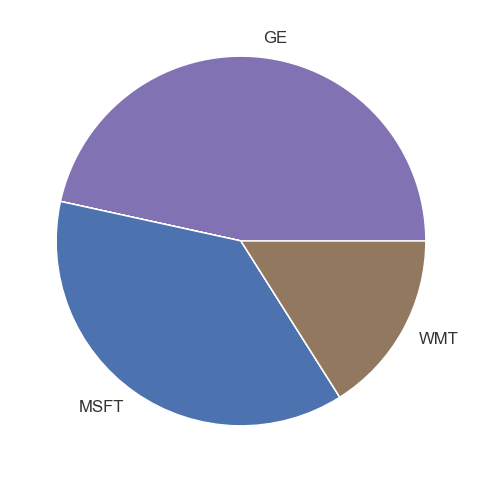

In [78]:
weights = ef.clean_weights()
pd.Series(weights).plot.pie()

In [93]:
def get_weights(input_ef):
    ef1 = input_ef.deepcopy()
    ef1.max_sharpe()
    weights = ef1.clean_weights()
    df1 = pd.DataFrame(weights, index=['Weight'])
    df1 = df1.T
    df1 = df1[df1['Weight'] != 0]  # Remove 0 values
    return df1

In [94]:
df_weights = get_weights(ef.deepcopy())

In [96]:
ef, cov_matrix = test_ef()

[*********************100%%**********************]  16 of 16 completed


In [95]:
df_weights

,Weight
GE,0.46567
MSFT,0.37414
WMT,0.16019


In [97]:
str(round(weighted_esg(df_weights), 2))

'28.71'

In [87]:
def get_esg_score(ticker):
    link = f'https://www.finance.yahoo.com/quote/{ticker}/sustainability?p={ticker}'
    headers = {
        'user-agent': 'Mozilla/5.0 (Windows NT 10.0; Win64; x64) AppleWebKit/537.36 (KHTML, like Gecko) '
                      'Chrome/95.0.4638.54 Safari/537.36 Edg/95.0.1020.30', }
    res = requests.get(link, headers=headers)
    soup = BeautifulSoup(res.content, 'html.parser')

    score = soup.find('div', {'class': 'Fz(36px) Fw(600) D(ib) Mend(5px)'}).text
    risk = soup.find('div', {'class': 'Fz(s) Fw(500) smartphone_Pstart(4px)'}).text
    return score, risk


def weighted_esg(df):
    sum = 0
    for index, row in df.iterrows():
        score, _ = get_esg_score(index)
        sum += float(score) * row['Weight']
    return sum

In [88]:
score = weighted_esg(df1)
print(score)

28.709319999999998


In [ ]:
def plot_weights(ef):
    ef.max_sharpe()
    weights = ef.clean_weights()
    df = pd.DataFrame(weights,index=['Weight'])
    df = df.T
    df = df[df['Weight']!=0] # Remove 0 values
    fig = px.pie(df,values='Weight',names=df.index)
    return fig

In [ ]:
plot_weights(ef2)

In [9]:
ef.max_sharpe()
ef.portfolio_performance(verbose=True)

Expected annual return: 25.4%
Annual volatility: 22.1%
Sharpe Ratio: 1.06


(0.2535719095254672, 0.2205031405726748, 1.0592679492856707)

In [ ]:
ef = EfficientFrontier(mu2, cov_matrix2, weight_bounds=(None, None))

fig, ax = plt.subplots()
plotting.plot_efficient_frontier(ef, ax=ax, show_assets=True)
plt.show()

In [ ]:
ef = EfficientFrontier(mu2, cov_matrix2, weight_bounds=(None, None))
fig, ax = plt.subplots()
ef_max_sharpe = ef.deepcopy()


# Find the tangency portfolio
ef_max_sharpe.max_sharpe()
ret_tangent, std_tangent, _ = ef_max_sharpe.portfolio_performance()
ax.scatter(std_tangent, ret_tangent, marker="*", s=100, c="r", label="Max Sharpe")

# Min Volatility
ef_min_vol = ef.deepcopy()
ef_min_vol.min_volatility()
vol_ret, vol_std, _ = ef_min_vol.portfolio_performance()
ax.scatter(vol_std, vol_ret, marker="*", s=100, c="g", label="Min Volatility")

plotting.plot_efficient_frontier(ef, ax=ax, show_assets=False)

# Generate random portfolios
n_samples = 10000
w = np.random.dirichlet(np.ones(ef.n_assets), n_samples)
rets = w.dot(ef.expected_returns)
stds = np.sqrt(np.diag(w @ ef.cov_matrix @ w.T))
sharpes = rets / stds
ax.scatter(stds, rets, marker=".", c=sharpes, cmap="viridis_r")

# Output
ax.set_title("Efficient Frontier with random portfolios")
ax.legend()
plt.tight_layout()
plt.show()

In [ ]:
def plot_ef_line(
    opt,
    ef_param="return",
    ef_param_range=None,
    points=100,
    ax=None,
    show_assets=True,
    show_tickers=False,
    **kwargs
):

    ax = ax or plt.gca()

    if isinstance(opt, CLA):
        ax = _plot_cla(
            opt, points, ax=ax, show_assets=show_assets, show_tickers=show_tickers
        )
    elif isinstance(opt, EfficientFrontier):
        if ef_param_range is None:
            ef_param_range = _ef_default_returns_range(opt, points)

        ax = _plot_ef(
            opt,
            ef_param,
            ef_param_range,
            ax=ax,
            show_assets=show_assets,
            show_tickers=show_tickers,
        )
    else:
        raise NotImplementedError("Please pass EfficientFrontier or CLA object")

    ax.legend()
    ax.set_xlabel("Volatility")
    ax.set_ylabel("Return")

    _plot_io(**kwargs)
    return ax


In [ ]:
def _plot_ef(ef, ef_param='return', ef_param_range, ax, show_tickers):
    """
    Helper function to plot the efficient frontier from an EfficientFrontier object
    """
    mus, sigmas = [], []

    # Create a portfolio for each value of ef_param_range
    for param_value in ef_param_range:
        try:
            if ef_param == "utility":
                ef.max_quadratic_utility(param_value)
            elif ef_param == "risk":
                ef.efficient_risk(param_value)
            elif ef_param == "return":
                ef.efficient_return(param_value)
            else:
                raise NotImplementedError(
                    "ef_param should be one of {'utility', 'risk', 'return'}"
                )
        except exceptions.OptimizationError:
            continue
        except ValueError:
            warnings.warn(
                "Could not construct portfolio for parameter value {:.3f}".format(
                    param_value
                )
            )

        ret, sigma, _ = ef.portfolio_performance()
        mus.append(ret)
        sigmas.append(sigma)

    ax.plot(sigmas, mus, label="Efficient frontier")

    asset_mu = ef.expected_returns
    asset_sigma = np.sqrt(np.diag(ef.cov_matrix))
    
    return ax

In [ ]:
ef = EfficientFrontier(mu2, cov_matrix2, weight_bounds=(None, None))


def plot_ef_with_random(ef, n_samples=10000):
    fig, ax = plt.subplots()
    ef_max_sharpe = ef.deepcopy()
    ef_min_vol = ef.deepcopy()

    # Find the tangency portfolio
    ef_max_sharpe.max_sharpe()
    ret_tangent, std_tangent, _ = ef_max_sharpe.portfolio_performance()
    ax.scatter(std_tangent, ret_tangent, marker="*", s=100, c="r", label="Max Sharpe")

    # Min Volatility
    ef_min_vol.min_volatility()
    vol_ret, vol_std, _ = ef_min_vol.portfolio_performance()
    ax.scatter(vol_std, vol_ret, marker="*", s=100, c="g", label="Min Volatility")


    # Generate random portfolios
    w = np.random.dirichlet(np.ones(ef.n_assets), n_samples)
    rets = w.dot(ef.expected_returns)
    stds = np.sqrt(np.diag(w @ ef.cov_matrix @ w.T))
    sharpes = rets / stds
    ax.scatter(stds, rets, marker=".", c=sharpes, cmap="viridis_r")

    # Output
    plotting.plot_efficient_frontier(ef, ax=ax, show_assets=False)
    ax.set_title("Efficient Frontier with random portfolios")
    ax.legend()
    plt.tight_layout()
    
    st.pyplot(fig)

In [2]:
def plot_ef_with_random(ef, output=None, n_samples=10000):
    fig, ax = plt.subplots()
    ef_max_sharpe = ef.deepcopy()
    ef_min_vol = ef.deepcopy()

    # Find the tangency portfolio
    ef_max_sharpe.max_sharpe()
    ret_tangent, std_tangent, _ = ef_max_sharpe.portfolio_performance()
    ax.scatter(std_tangent, ret_tangent, marker="*", s=100, c="r", label="Max Sharpe")

    # Min Volatility
    ef_min_vol.min_volatility()
    vol_ret, vol_std, _ = ef_min_vol.portfolio_performance()
    ax.scatter(vol_std, vol_ret, marker="*", s=100, c="g", label="Min Volatility")


    # Generate random portfolios
    w = np.random.dirichlet(np.ones(ef.n_assets), n_samples)
    rets = w.dot(ef.expected_returns)
    stds = np.sqrt(np.diag(w @ ef.cov_matrix @ w.T))
    sharpes = rets / stds
    ax.scatter(stds, rets, marker=".", c=sharpes, cmap="viridis_r")

    # Output
    plotting.plot_efficient_frontier(ef, ax=ax, show_assets=False)
    ax.set_title("Efficient Frontier with random portfolios")
    ax.legend()
    plt.tight_layout()
    plt.show()

In [4]:
def plot_weights(ef):
    ef2 = ef.deepcopy()
    ef2.max_sharpe()
    weights = ef2.clean_weights()
    df = pd.DataFrame(weights,index=['Weight'])
    df = df.T
    df = df[df['Weight']!=0] # Remove 0 values
    fig = px.pie(df,values='Weight',names=df.index)
    return fig

In [71]:
ef_o = test_ef()
ef = ef_o.deepcopy()

[*********************100%%**********************]  16 of 16 completed
